# Value based computations


In [1]:
#| default_exp explore

In [2]:
#| export
import numpy as np
from graphviz import Digraph
import math
import random

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [73]:
#| export 
class Value:
    
    def __init__(self, data: float, _prev:set=(), _op: str='', label='') -> None:
        self.data = data
        self._prev = _prev
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad: float = 0.
        
    def __repr__(self) -> str:
        return f"Value({self.data = }, {self.grad=}, {self.label = })"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else (Value(other))
        out = Value(self.data + other.data, _prev=(self,other),_op='+')
        
        def _backward():
            # we do += to manage the case where we add with itself and it overrides the gradient. So we always add grad. 
            self.grad += 1. * out.grad
            other.grad += 1. * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self, other):
        return self + (-other)
        
    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else (Value(other))
        out =  Value(self.data * other.data, _prev=(self,other),_op='*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Other should be either int or float"
        out = Value(self.data**other, _prev=(self,), _op='**')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
            
        out._backward = _backward
        
        return out
        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), _prev=(self,), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
        
    
    def tanh(self):
        x = self.data
        n = (1-math.exp(-2*x))/(1+math.exp(-2*x))
        out = Value(n, _prev=(self,), _op='tanh')
        
        def _backward():
            self.grad += (1-n**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(node: Value):
            if node not in visited:
                visited.add(node)
                for prev in node._prev:
                    build_topo(prev)
                topo.append(node)

        build_topo(self) 
        topo  
        self.grad = 1.
        for node in reversed(topo):
            node._backward()

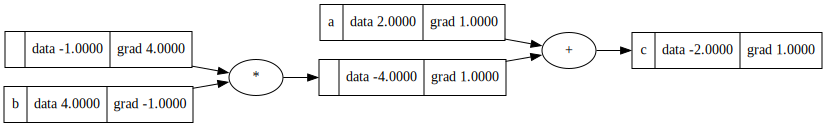

In [74]:
a = Value(2., label='a')
b = Value(4., label='b')
#a+1
#a*2
2*a
#1*a
#1+a
#a.exp()
#a/b
c=a-b; c.label='c'

c.backward()
draw_dot(c)

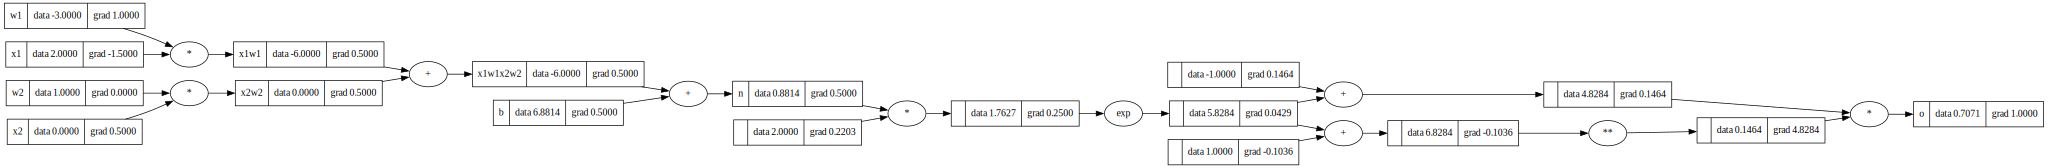

In [75]:
x1 = Value(2., label='x1')
x2 = Value(0., label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1, label='w2')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
b = Value(6.8813735870195432, label='b')
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b; n.label='n'
e = (2*n).exp()
o = (e-1)/(e+1)
#o = n.tanh()
o.label = 'o'


#o.grad = 1.
#o._backward()
#n._backward()
#x1w1x2w2._backward()
#x1w1._backward()
##b._backward()
#x2w2._backward()
#x2._backward()
o.backward()
draw_dot(o)


In [76]:
class Module:
    def parameters(self):
        return []

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.
            


In [77]:
class Neuron(Module):
    
    def __init__(self, nin:int, activation='tanh') -> None:
        self.w = [Value(random.uniform(-1,1))for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.activation = activation
        
    
    def __call__(self, x):
        out = sum([wi*xi for wi,xi in zip(self.w, x)], self.b)
        if self.activation=='tanh':
            out = out.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
    
x =[2., 3., -1.]
n = Neuron(3)
n(x)
n.parameters()

[Value(self.data = -0.8864184957139518, self.grad=0.0, self.label = ''),
 Value(self.data = 0.8397456443671873, self.grad=0.0, self.label = ''),
 Value(self.data = -0.7991337583059006, self.grad=0.0, self.label = ''),
 Value(self.data = 0.11189342017367565, self.grad=0.0, self.label = '')]

In [78]:
class Layer(Module):
    
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin)for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
l = Layer(3,4)
l(x)
l.parameters()

[Value(self.data = -0.427280033764017, self.grad=0.0, self.label = ''),
 Value(self.data = 0.7510805322357965, self.grad=0.0, self.label = ''),
 Value(self.data = 0.8301498598350983, self.grad=0.0, self.label = ''),
 Value(self.data = -0.490817108445335, self.grad=0.0, self.label = ''),
 Value(self.data = -0.35880289464723325, self.grad=0.0, self.label = ''),
 Value(self.data = 0.3775271637572202, self.grad=0.0, self.label = ''),
 Value(self.data = 0.28449661881000354, self.grad=0.0, self.label = ''),
 Value(self.data = 0.08204574523201025, self.grad=0.0, self.label = ''),
 Value(self.data = 0.17781941993246075, self.grad=0.0, self.label = ''),
 Value(self.data = 0.07192455642656559, self.grad=0.0, self.label = ''),
 Value(self.data = -0.9309296179504123, self.grad=0.0, self.label = ''),
 Value(self.data = -0.35479024223149014, self.grad=0.0, self.label = ''),
 Value(self.data = 0.6657026268528405, self.grad=0.0, self.label = ''),
 Value(self.data = 0.8698787710044755, self.grad=0.0, s

In [79]:
class MLP(Module):
    
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) 
                       for i 
                       in range(len(nouts))]
        
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]
        


In [80]:
m = MLP(3,[4,4,1])
out = m(x)
out


Value(self.data = -0.24422166916258942, self.grad=0.0, self.label = '')

In [81]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [82]:
ypred =[m(x) for x in xs]
ypred



[Value(self.data = -0.24422166916258942, self.grad=0.0, self.label = ''),
 Value(self.data = -0.5107883769393252, self.grad=0.0, self.label = ''),
 Value(self.data = -0.47113637375146894, self.grad=0.0, self.label = ''),
 Value(self.data = -0.3720755391348969, self.grad=0.0, self.label = '')]

In [84]:
#lr = 0.1
epoch_nb = 100
for k in range(epoch_nb):
    # forward pass
    ypred =[m(x) for x in xs]
    loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys, ypred)])
      
    
    # backward pass
    # zero out grads because during backward we do a += so we accumulate past gradients. We must flush gradient to 0.
    m.zero_grad()
    loss.backward()
    
    lr = 1-0.9*k/epoch_nb
    
    # parameter update
    for p in m.parameters():
        p.data += -lr*p.grad
     
    #print(k, loss.data, lr)  

# Demo exemple

In [85]:
import random
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [86]:
np.random.seed(1337)
random.seed(1337)

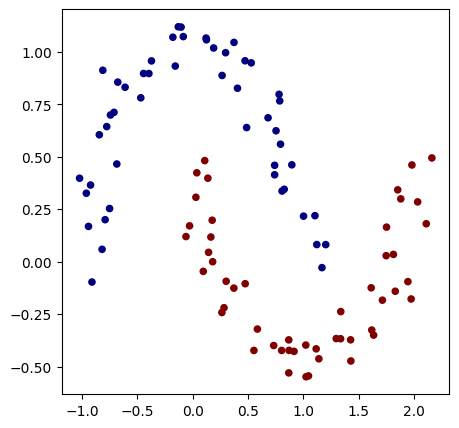

In [87]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [88]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [90]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(self.data = 0.7840043023159258, self.grad=0.0, self.label = '') 0.68
